# HW-3: Pre-trained computer vision models 

Author: J. Hickman

**Overview:**

* In deep learning we don't always have to train our neural networks from scratch
* Often "pre-trained models" exist which we can "pull of the shelf" and use as part of a data processing pipeline. 
* In this assignment, we will use the popular "You only look once" (YOLO) deep learning algorithm to do object detection.
  * https://pytorch.org/hub/ultralytics_yolov5/
* Assume you are working for a company interested in traffic patterns and driver behavior 
  * For example, a car-insurance company, a traffic data analytics firm, or a self driving car start-up 
* This company has "dash-camera" footage from various cars in their "fleet" 
* As an initial proof of concept they want you to write a code to track the locations of other vehicles from the recordings 
* They also want you to analyze the time-dependence of traffic patterns found in the videos.

**Submission:**

* You need to upload ONE document to Canvas when you are done
  * (1) A PDF (or HTML) of the completed form of the "HW-3.ipynb" document 
* The final uploaded version should NOT have any code-errors present 
* All outputs must be visible in the uploaded version, including code-cell outputs, images, graphs, etc

**Note**:

* There are many ways to do this assignment and the methods below are guidelines not rules.
* If you find more efficient ways to complete the objectives then feel free to do it however you want. 
* **IMPORTANT: START SMALL THEN SCALE UP** 
  * Get everything working for a simple case with a few images, once everything seems to be working correctly then run it on the entire data set

**Data source**:

* Dash cam footage: https://www.youtube.com/watch?v=9qy4lExIetk
* Website to download youtube videos: https://en.y2mate.is/67/



### Import

In [49]:
import torch
from IPython.display import Image
import matplotlib.pyplot as plt
import shutil 
import os

print(torch.__version__)

2.4.1


#### Part-3.0 

Open the file "video-res-2.mp4" and watch a few minutes to get familiar with the content

#### Part-3.1: Pre-processing

* The video is 2hr8min55s which is 2*60*60+8*60+55=7735 seconds 
* The frame rate for the video is roughly 30 frames per second 
* So there are around 7735*30=232050 frames
* Write code to read and convert the video "video-res-2.mp4" into an ORDERED set of images 
* Include a parameter to save frames every N seconds 
* Don't save every frame, at first save frames every 50 seconds, that will be around 155 images
* Once everything is working, save frames every 10 seconds and re-run the code for the final product.
* Save the images to a folder "frames" with the convention 
  * "frames/00010.jpg" for the frame 10 seconds into the video
  * "frames/00020.jpg" for the frame 20 seconds into the video and so on


In [50]:
#INSERT CODE HERE 
import cv2
import os

video_path = "/Users/zp/Desktop/dsan6600/hw-03/video-res-2.mp4"
output_folder = "/Users/zp/Desktop/dsan6600/hw-03/frames"
frame_interval = 10 

os.makedirs(output_folder, exist_ok=True)


cap = cv2.VideoCapture(video_path)
print(type(cap))  
fps = int(cap.get(cv2.CAP_PROP_FPS))

save_every_n_frames = fps * frame_interval

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  

    if frame_count % save_every_n_frames == 0:
       timestamp_sec = frame_count // fps
       filename = f"{output_folder}/{timestamp_sec:05d}.jpg"
        
       cv2.imwrite(filename, frame)

    frame_count += 1

cap.release()


<class 'cv2.VideoCapture'>


#### Part-3.2: Explore the model 

Before processing the video data, we want to make sure we can get YOLO working correctly for a few images

In [51]:
#INSERT CODE TO LOAD THE YOLO MODEL USING PYTORCH
model = torch.hub.load("ultralytics/yolov5", "yolov5s",pretrained = True)  

Using cache found in /Users/zp/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-3-10 Python-3.12.2 torch-2.4.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [52]:
# AT FIRST USE THE FOLLOWING IMAGES AS A TEST CASE
images=['frames/00050.jpg','frames/00200.jpg']  

In [53]:
# INSERT CODE TO EVALUATE THE YOLO MODEL ON THESE IMAGES
results = model(images)

/Users/zp/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [54]:
# WHEN WORKING IN PYTHON WITH AN OBJECT OF AN UN-FAMILIAR CLASS IT IS 
# VERY USEFUL TO FIGURE OUT THE CLASSES ATTRIBUTES AND METHOD
print(type(results))

<class 'models.common.Detections'>


In [55]:
# INSERT CODE TO FIGURE OUT WHAT THE OBJECTS ATTRIBUTES OF THE "results" OBJECT ARE
print(results.__dict__.keys())


dict_keys(['ims', 'pred', 'names', 'files', 'times', 'xyxy', 'xywh', 'xyxyn', 'xywhn', 'n', 't', 's'])


In [56]:
#  INSERT CODE TO FIGURE OUT WHAT THE OBJECTS METHODS OF THE "results" OBJECT ARE
print(dir(results))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_run', 'crop', 'files', 'ims', 'n', 'names', 'pandas', 'pred', 'print', 'render', 's', 'save', 'show', 't', 'times', 'tolist', 'xywh', 'xywhn', 'xyxy', 'xyxyn']


In [57]:
# PRINT A SUMMARY OF THE RESULT
results.print()

image 1/2: 240x426 2 cars
image 2/2: 240x426 5 cars, 4 trucks
Speed: 8.4ms pre-process, 69.1ms inference, 0.3ms NMS per image at shape (2, 3, 384, 640)


In [58]:
#THE INFORMATION ABOUT THE BOUNDING BOXES CAN BE EXTRACTED AS FOLLOWS
print(results.pandas().xyxy[1])

         xmin        ymin        xmax        ymax  confidence  class   name
0  229.353577  138.227371  256.387390  165.780991    0.821411      7  truck
1  347.833832  119.458221  425.631348  183.702805    0.804607      7  truck
2  123.357971  133.133896  187.613327  176.771652    0.698513      7  truck
3  277.773499  145.475723  312.404694  171.753342    0.685367      2    car
4  198.673431  145.056534  216.073120  159.018173    0.681009      2    car
5   70.106514  149.759705   90.579987  176.642563    0.574722      7  truck
6  314.468323  151.671692  327.972595  161.770691    0.566508      2    car
7  267.722351  149.884720  278.864594  156.853378    0.337026      2    car
8  258.699371  148.832932  266.880890  156.184402    0.299966      2    car


In [59]:
# INSERT CODE TO REMOVE THE FOLDER "runs" IF IT EXISTS THEN RUN "results.save()"
if os.path.exists('runs'):
    shutil.rmtree('runs')
    
results.save()


Saved 2 images to runs/detect/exp


In [60]:
import shutil
import os

# Remove "runs" folder if it exists
runs_dir = "runs"
if os.path.exists(runs_dir) and os.path.isdir(runs_dir):
    shutil.rmtree(runs_dir)
    
results.save()



Saved 2 images to runs/detect/exp


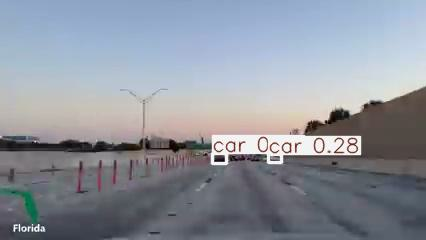

In [61]:
# LOOK AT THE FIRST IMAGE
Image("runs/detect/exp/00050.jpg")

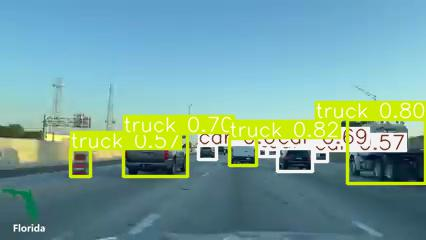

In [62]:
Image("runs/detect/exp/00200.jpg")

#### Part-3.3: Explore the results  

The following code will plot the image and add a vertical line roughly down the center of the car's hood

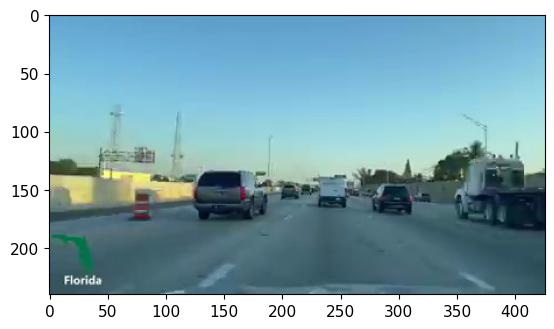

In [63]:
%matplotlib inline
plt.imshow(results.ims[1])
plt.show()

image 1/2: 240x426 2 cars
image 2/2: 240x426 5 cars, 4 trucks
Speed: 8.4ms pre-process, 69.1ms inference, 0.3ms NMS per image at shape (2, 3, 384, 640)


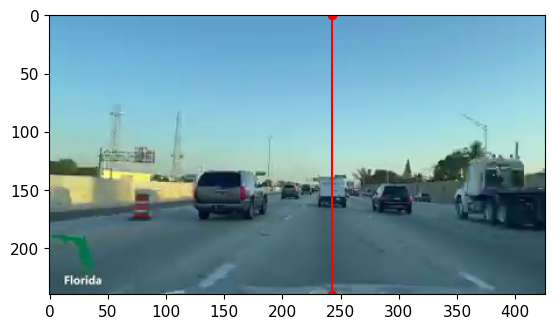

In [ ]:
#PLOT IMAGE WITH REGIONAL SUB-DIVIDING LINES
# result attribute doesn't have imgs, instead it has ims
def plot_lines(img):
    YMAX=img.shape[0]
    XMAX=img.shape[1]
    XCENTER=0.57*XMAX

    x1 = XCENTER; y1 = 0; x2 = XCENTER; y2 = YMAX 
    plt.plot([x1,x2], [y1,y2], marker = 'o',color="red")
    plt.imshow(img)
    plt.show()

results.print()
plot_lines(results.ims[1])



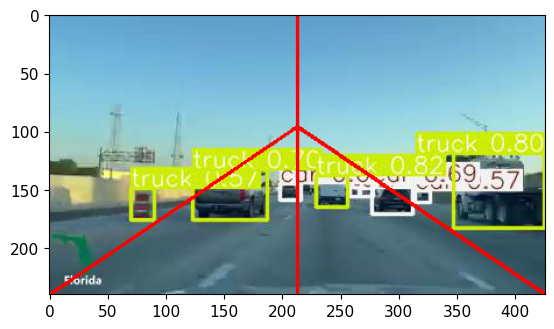

In [65]:
# INSERT CODE TO MODIFY THE FUNCTION TO GENERATE THE FOLLOWING IMAGE TO ROUGHLY ISOLATE THE LANE
# YOU CAN JUST USE GEOMETRY TO DO THIS
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

img = np.array(Image.open("runs/detect/exp/00200.jpg"))  

h, w, _ = img.shape
center_x = w // 2

lane_img = img.copy()

cv2.line(lane_img, (center_x, 0), (center_x, h), (255,0, 0), 2)  

bottom_y = h
vanish_y = int(h * 0.4)

cv2.line(lane_img, (center_x, vanish_y), (0, bottom_y), (255, 0, 0), 2)
cv2.line(lane_img, (center_x, vanish_y), (w, bottom_y), (255, 0, 0), 2)

plt.imshow(lane_img)
plt.show()


Insert a function to output a modified version of the results.pandas().xyxy[i] data-frame in the following ways 

* normalize (scale) the xmin, xmax by the width of the image and ymin, ymax by the height --> HxW=1x1 
* compute the area and center of each box using the normalized coordinates
* add a column named "nearby" which is True if normalized_area>0.05
* **Optional**: Use The geometric lane construction from the previous image and the location of the box center to compute which lane (left,center,right) nearby vehicles are in
 
```
       xmin      ymin      xmax      ymax  confidence  ...   name nearby  \
0  0.677506  0.515625  0.771468  0.680202    0.859959  ...  truck  False   
1  0.831234  0.617149  0.977826  0.743249    0.851794  ...    car  False   
2  0.002621  0.457946  0.410202  0.926958    0.820941  ...  truck   True   
3  0.547734  0.598833  0.656238  0.750011    0.581989  ...    car  False   
4  0.473275  0.594087  0.518594  0.662508    0.503990  ...    car  False   

       area  x_center  y_center  
0  0.015464  0.724487  0.597913  
1  0.018485  0.904530  0.680199  
2  0.191160  0.206412  0.692452  
3  0.016403  0.601986  0.674422  
4  0.003101  0.495935  0.628297  
```

In [66]:
#INSERT CODE TO MODIFY THE DATAFRAME 
def new_df(results, i, height, width, assign_lanes=True):
    import pandas as pd

    df = results.pandas().xyxy[i].copy()

    df["xmin"] = df["xmin"] / width
    df["xmax"] = df["xmax"] / width
    df["ymin"] = df["ymin"] / height
    df["ymax"] = df["ymax"] / height

    df["area"] = (df["xmax"] - df["xmin"]) * (df["ymax"] - df["ymin"])
    df["x_center"] = (df["xmin"] + df["xmax"]) / 2
    df["y_center"] = (df["ymin"] + df["ymax"]) / 2

    df["nearby"] = df["area"] > 0.05

    if assign_lanes:
        def classify_lane(xc):
            if xc < 0.33:
                return "left"
            elif xc < 0.66:
                return "center"
            else:
                return "right"
        df["lane"] = df["x_center"].apply(classify_lane)

    return df


image = results.ims[0]  
height, width = image.shape[:2]

df_mod = new_df(results, i=0, height=height, width=width)
print(df_mod[["xmin", "ymin", "xmax", "ymax", "area", "x_center", "y_center", "nearby", "lane"]])



       xmin      ymin      xmax      ymax      area  x_center  y_center  \
0  0.630620  0.644941  0.660361  0.677197  0.000959  0.645490  0.661069   
1  0.498234  0.638034  0.532114  0.679227  0.001396  0.515174  0.658630   

   nearby    lane  
0   False  center  
1   False  center  


### Part-3.4: Process all images

In [67]:
# INSERT CODE TO FORM AN ORDERED (SORTED) LIST OF ALL IMAGES IN "frames" 

frames_dir = "/Users/zp/Desktop/dsan6600/hw-03/frames"

image_files = [f for f in os.listdir(frames_dir) if f.endswith(".jpg")]
image_files_sorted = sorted(image_files, key=lambda x: int(os.path.splitext(x)[0]))
image_paths_sorted = [os.path.join(frames_dir, fname) for fname in image_files_sorted]




In [68]:
# INSERT CODE TO RUN YOLO ON THE COMPLETE LIST
images = [cv2.imread(path) for path in image_paths_sorted]
results = model(images)



/Users/zp/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [69]:
results.save()

Saved 800 images to runs/detect/exp2


### Part-3.5: Time-series analysis 

Loop over the results and build arrays with time-series data for the following 
* The frames should be ordered so you can treat the index as a "time" variables
* Total number num_cars and num_trucks in each frame
* num_neighbor = Number of neighboring cars and trucks (use normalized box area > .05 to signify a nearby car or truck)

In [70]:
# 3.5.1: INSERT CODE TO LOOP OVER RESULTS AND BUILD ARRAYS
num_cars = []
num_trucks = []
num_neighbor = []

height, width = images[0].shape[:2]

for res in results.pandas().xyxy:
    df = res.copy()

    df["xmin"] = df["xmin"] / width
    df["xmax"] = df["xmax"] / width
    df["ymin"] = df["ymin"] / height
    df["ymax"] = df["ymax"] / height

    df["area"] = (df["xmax"] - df["xmin"]) * (df["ymax"] - df["ymin"])

    df["nearby"] = df["area"] > 0.05

    car_mask = df["name"] == "car"
    truck_mask = df["name"] == "truck"
    nearby_mask = df["nearby"]

    num_cars.append(car_mask.sum())
    num_trucks.append(truck_mask.sum())

    num_nearby = ((car_mask | truck_mask) & nearby_mask).sum()
    num_neighbor.append(num_nearby)

print("CAR\n", num_cars)
print("TRUCKS\n", num_trucks)
print("NEARBY\n", num_neighbor)


CAR
 [0, 3, 0, 3, 5, 2, 5, 8, 3, 6, 5, 6, 5, 3, 6, 9, 6, 6, 1, 3, 4, 6, 6, 5, 5, 1, 1, 0, 3, 1, 5, 1, 2, 2, 1, 0, 0, 4, 1, 3, 0, 0, 3, 3, 4, 5, 8, 7, 4, 8, 0, 7, 2, 2, 4, 0, 4, 5, 4, 0, 2, 1, 2, 1, 0, 0, 1, 0, 0, 5, 6, 1, 1, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 4, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 1, 0, 2, 1, 0, 3, 3, 1, 2, 4, 0, 2, 0, 2, 3, 0, 1, 0, 5, 1, 1, 0, 1, 0, 0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 0, 0, 3, 0, 1, 0, 5, 2, 2, 0, 1, 2, 1, 0, 2, 1, 2, 2, 4, 1, 3, 1, 3, 4, 2, 0, 1, 1, 2, 3, 0, 4, 0, 4, 1, 2, 1, 0, 4, 0, 2, 5, 5, 3, 3, 1, 2, 2, 1, 1, 2, 4, 1, 4, 0, 1, 1, 2, 3, 1, 6, 0, 3, 3, 1, 1, 1, 1, 3, 1, 3, 4, 3, 3, 1, 0, 1, 1, 0, 3, 0, 2, 1, 0, 3, 4, 2, 2, 5, 4, 6, 3, 2, 3, 3, 4, 5, 3, 0, 2, 0, 1, 1, 2, 1, 0, 1, 2, 1, 1, 2, 1, 0, 3, 3, 2, 4, 3, 2, 3, 2, 4, 1, 4, 3, 3, 2, 3, 0, 0, 3, 1, 3, 2, 0, 1, 1, 5, 2, 0, 0, 1, 0, 1, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 0, 1, 2, 0, 4, 0, 1, 0, 0, 1, 1, 1, 5, 0, 0, 0, 0, 0, 3, 1, 2, 2, 0, 2, 0, 0, 3

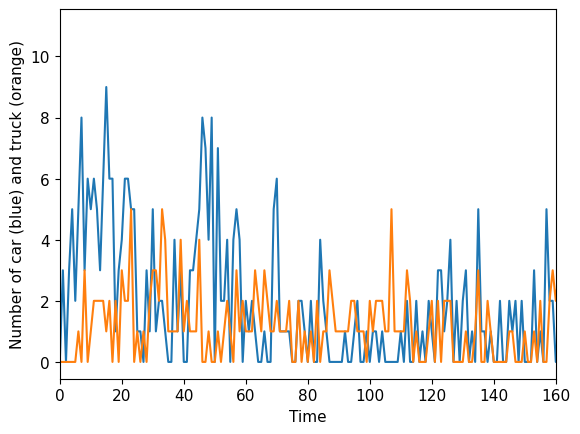

In [71]:
# INSERT CODE TO GENERATE THE FOLLOWING PLOT

plt.plot(num_cars )
plt.plot(num_trucks)
plt.xlim(0, 160)
plt.xticks(range(0, 161, 20))  
plt.xlabel("Time")
plt.ylabel("Number of car (blue) and truck (orange)")
plt.show()


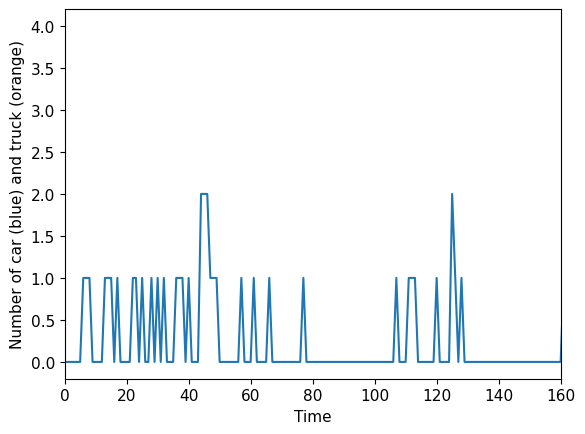

In [72]:
# INSERT CODE TO GENERATE THE FOLLOWING PLOT

plt.plot(num_neighbor)
plt.xlim(0, 160)
plt.xticks(range(0, 161, 20)) 
plt.xlabel("Time")
plt.ylabel("Number of car (blue) and truck (orange)")
plt.show()

### Optional: Dynamic analysis (more advanced)

* Save more frames and see if you can write a script to track near-by neighboring cars from one frame to the next
  * Using this information, compute some measure of relative velocity of passing cars 
  * Plot this average velocity as a time series and discuss the meaning
* Research the mathematics of "perspective" and see if you can encode the math to predict an estimate for the distance to neighboring vehicles from the area of the box
  
